# Определение языка и VK API

В данном задании вам нужно будет:

* используя API Вконтакте, скачать комментарии к первым ста постам из пяти сообществ
* натренировать модель распознавания языков на статьях из Википедии.
* распознать язык всех комментариев, где в тексте есть 10 и более символов, и построить статистику

## VK API

Для подключения к ВКонтакте мы будем использовать VK API. Здесь есть документация к этой библиотеке https://vk-api.readthedocs.io/en/latest/

In [0]:
!pip install vk_api

In [0]:
import vk_api

# здесь нужно ввести данные своего аккаунта
# когда будете сдавать, не забудьте убрать эти две строчки из ноутбука
user = '' # вставьте сюда свой номер телефона
password = '' # вставьте сюда свой пароль

# авторизация
vk_session = vk_api.VkApi(login=user, password=password)
vk_session.auth()

vk = vk_session.get_api() # объект с API

Получить записи со страницы можно с помощью метода `wall.get`. Он принимает параметр `domain` — короткое имя пользователя или сообщества — и `count` — количество записей, которое вы хотите получить (максимум — 100). По Список методов для работы со стенами: https://vk.com/dev/wall

Например, вот так можно получить последние две записи с вот этой страницы https://vk.com/futureisnow. Выдача представляет собой словарь, в котором в поле `items` записан список словарей, содержащий информацию о каждой из записи. 

In [0]:
vk.wall.get(domain="futureisnow", count=2)

С помощью метода `groups.getById` можно получить информацию о сообществе, в том числе его id.

In [0]:
vk.groups.getById(group_ids="futureisnow")

Скачайте информацию о последних ста записях в следующих пабликах: https://vk.com/futureisnow, https://vk.com/eternalclassic, https://vk.com/ukrlit_memes, https://vk.com/ukrainer_net, https://vk.com/amanzohel, https://vk.com/barg_kurumk_culture

In [0]:
# список domain'ов, чтобы вам не копировать их самими :)
publics = ["futureisnow",
           "eternalclassic",
           "ukrlit_memes",
           "ukrainer_net",
           "amanzohel",
           "barg_kurumk_culture"]

In [0]:
items = {} # ключи — это паблики

for public in publics:
  items[public] = vk.wall.get(domain=public, count=100)

Найдите в документации (https://vk.com/dev/wall) метод для получения комментариев и получите первые сто комментариев каждого поста из выборки для каждого паблика. Выкидывайте все комментарии, которые содержат меньше 10 символов.

In [0]:
import re 
import string

In [0]:
emoji = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)

def clean(text):
  text = emoji.sub('', text)
  for s in trash:
    text = text.replace(s, '')
  return text

In [0]:
corpora = {}

trash = string.punctuation

for k in items.keys():
  public_corpora = []
  for post in items[k]['items']:
    comments = vk.wall.getComments(owner_id=post['owner_id'], post_id=post['id'])
    for comment in comments['items']:
      try:
        text = clean(comment['text'])
        if len(text) >= 10:
          public_corpora.append(text)
      except KeyError:
        pass
  corpora[k] = public_corpora


In [55]:
for k in corpora.keys():
  print(k, len(corpora[k]))

futureisnow 744
eternalclassic 539
ukrlit_memes 213
ukrainer_net 191
amanzohel 111
barg_kurumk_culture 130


**Задание со звездочкой:** вы могли заметить, что если обращаться к каждому посту отдельно, то все занимает довольно продолжительное время (около пяти минут). Найдите в документации vk_api способ сделать это быстрее.

In [0]:
corpora = {}

# ваш улучшенный код

## Тренировка моделей

В наших комментариях встречались русский, украинский, английский и бурятский.

In [0]:
langs = {'ru', 'uk', 'en', 'bxr'}

Скачайте документы, на которых вы будете обучать свои модели. Для наших целей хорошо иметь для каждого языка корпус размером около 50 статей.

In [0]:
!pip install wikipedia

In [0]:
import wikipedia
from collections import Counter
import nltk

In [0]:
def get_texts_for_lang(lang, n):
    wiki_content = []
    wikipedia.set_lang(lang)
    pages = wikipedia.random(n)
    for page_name in pages:
        try:
            page = wikipedia.page(page_name)
            wiki_content.append("%s\n%s" % (page.title, page.content.replace('=', '')))
        except wikipedia.exceptions.WikipediaException:
            print("Skip %s" % page_name)
    return wiki_content

In [19]:
wiki_texts = {}
for lang in langs:
    wiki_texts[lang] = get_texts_for_lang(lang, 50)
    
for k in wiki_texts.keys():    
  print(k, len(wiki_texts[k]))

/usr/local/lib/python3.6/dist-packages/wikipedia/wikipedia.py:389: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.6/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Skip Андрій Кравченко (значення)
Skip Конта (значення)
Skip Талмуд-тора
Skip Смелов, Сергей Владиславович
Skip Кряжево
Skip Вэлли (округ)
Skip Райнфельден (значения)
Skip Rasamna Ala Al-Qalb Wajh Al-Watan
Skip Staunton, Gloucestershire
Skip Бурхан
Skip Сэлэнгэ
uk 47
ru 46
en 48
bxr 48


Сделайте определялку на частотах слов.

In [0]:
nltk.download("punkt")

def collect_freqlist(wiki_pages, max_len=100):
    freqlist = Counter()
    for text in wiki_pages:
        for word in nltk.word_tokenize(text.lower()):
            if word.isalpha():
                freqlist[word] += 1
    return dict(freqlist.most_common(max_len))
  
freq_lists = {}
for lang in langs:
    freq_lists[lang] = collect_freqlist(wiki_texts[lang])

In [0]:
def lang_detect_freq(freq_lists, text):
    counts = Counter()
    for lang, freq_list in freq_lists.items():
        freq_list = Counter(freq_list)
        for word in nltk.word_tokenize(text):
            counts[lang] += int(freq_list[word] > 0)
    return counts.most_common()

Сделайте определялку на символьных энграммах.

In [92]:
from sklearn import feature_extraction
from sklearn import pipeline
from sklearn import naive_bayes
import numpy as np

vectorizer = feature_extraction.text.TfidfVectorizer(ngram_range=(1, 5), analyzer='char')
clf = pipeline.Pipeline([
    ('vctr', feature_extraction.text.TfidfVectorizer(ngram_range=(1, 2), analyzer='char')),
    ('clf', naive_bayes.MultinomialNB())
])

all_texts = []
lang_indices = []
for lang in wiki_texts:
    all_texts.extend(wiki_texts[lang])
    lang_indices.extend([lang]*len(wiki_texts[lang]))
    
clf.fit(np.array(all_texts), np.array(lang_indices))

Pipeline(memory=None,
         steps=[('vctr',
                 TfidfVectorizer(analyzer='char', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

# Определение языка

Определите язык каждого комментария в каждом паблике с помощью определялки на частотах слов и покажите доли языков среди комментариев для каждого паблика.

In [0]:
lang_detects_freqs = {}

for public in corpora.keys():
  public_langs = []
  for text in corpora[public]:
    try:
      if lang_detect_freq(freq_lists, text)[0][1] > 0:
        public_langs.append(lang_detect_freq(freq_lists, text)[0][0])
      else:
        public_langs.append('none')
    except IndexError:
      public_langs.append('none')
  lang_detects_freqs[public] = Counter(public_langs)

In [96]:
lang_detects_freqs

{'amanzohel': Counter({'bxr': 11, 'none': 78, 'ru': 13, 'uk': 9}),
 'barg_kurumk_culture': Counter({'bxr': 12, 'none': 65, 'ru': 42, 'uk': 11}),
 'eternalclassic': Counter({'en': 271, 'none': 228, 'uk': 40}),
 'futureisnow': Counter({'en': 6, 'none': 310, 'ru': 267, 'uk': 161}),
 'ukrainer_net': Counter({'none': 71, 'ru': 12, 'uk': 108}),
 'ukrlit_memes': Counter({'en': 2, 'none': 92, 'ru': 19, 'uk': 100})}

In [0]:
import matplotlib.pyplot as plt

In [0]:
def draw_chart(public, dic):

  labels = dic[public].keys()
  values = dic[public].values()

  fig1, ax1 = plt.subplots()
  ax1.pie(values, labels=labels, startangle=90, autopct='%1.1f%%')

  plt.title(public)
  plt.show()

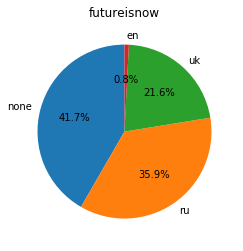

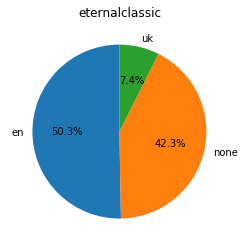

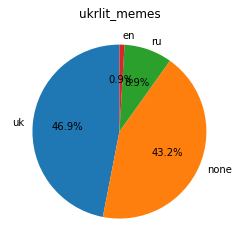

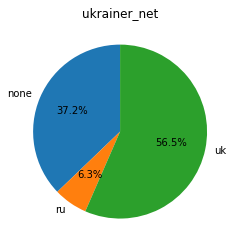

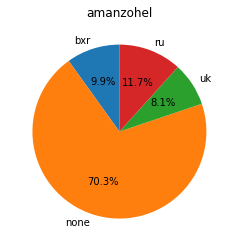

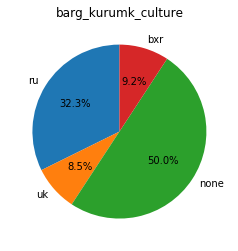

In [114]:
for public in publics:
  draw_chart(public, lang_detects_freqs)

Сделайте то же самое для определителя на символьных энграммах.

In [0]:
lang_detects_ngrams = {}

for public in corpora.keys():
  public_langs = clf.predict(corpora[public])
  lang_detects_ngrams[public] = Counter(public_langs)

In [94]:
lang_detects_ngrams

{'amanzohel': Counter({'bxr': 77, 'ru': 34}),
 'barg_kurumk_culture': Counter({'bxr': 37, 'ru': 92, 'uk': 1}),
 'eternalclassic': Counter({'en': 537, 'uk': 2}),
 'futureisnow': Counter({'bxr': 10, 'en': 38, 'ru': 685, 'uk': 11}),
 'ukrainer_net': Counter({'bxr': 1, 'en': 5, 'ru': 54, 'uk': 131}),
 'ukrlit_memes': Counter({'bxr': 4, 'en': 4, 'ru': 78, 'uk': 127})}

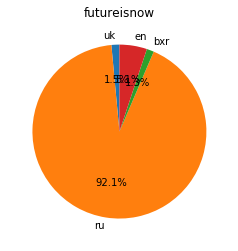

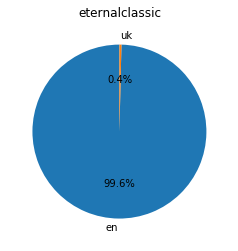

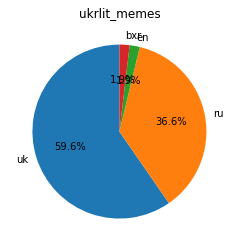

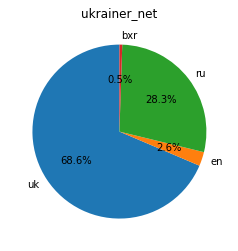

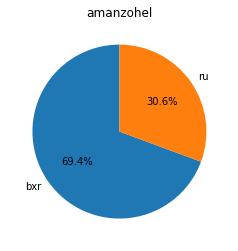

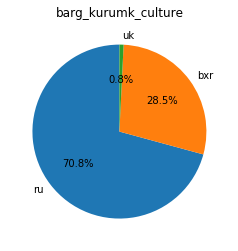

In [115]:
for public in publics:
  draw_chart(public, lang_detects_ngrams)

Обсудите работу каждого из классификаторов, обсудите ошибки, объясните разницу в результатах.

Проблемы классификатора по частотному списку:

- очень много постов, где не определился язык
- неоправданно много украинского в большинстве сообществ

Результат классификатора по энграммам кажется более приближенным к реальности хотя иногда появляется, например, не слишком ожидаемый бурятский.

Классификатор по частотному списку работает хуже, потому что сильно завязан на конкретных словах, которых может и не быть в коротких текстах комментариев. Кроме того, список частотных слов может быть не слишком общим в зависимости от того, какие статьи википедии попали в выборку (что если несколько страниц про котиков и котики станут очень частым словом?). 
Классификатор по энграммам не привязан к конкретным словам поэтому работает лучше. Но это не точно, потому что мы не пробовали считать долю правильных ответов.